### Set MINI = TRUE to run with mini sample

In [30]:
"""
For TAs: Set TRUE to run with mini sample 
"""
MINI = True

In [31]:
if MINI:
    train_days = [1]
    test_days = [8]
    EPOCHS = 3
else:
    train_days = [7]
    test_days = [8,9,10] 
    EPOCHS = 50

(MINI, EPOCHS, train_days, test_days)

(False, 50, [7], [8, 9, 10])

Dataset Can be directly downloaded from:
https://etsin.fairdata.fi/dataset/73eb48d7-4dbc-4a10-a52a-da745b47a649

In [32]:
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from torchinfo import summary
from torch.utils.data import DataLoader

from models.deep_lob import DeepLOB
from models.trans_lob import TransLOB
from models.deep_trans_lob import DeepTransLOB
from utils.crypto_loader import load_crypto
from utils.fi2010_loader import load_fi2010
from utils.training import train_validate, train, validate
from utils.plots import plot_training_history, plot_label_distributions
from utils.preprocessing import generate_labels, normalize_features

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [34]:
DATASET_TYPE = "fi2010"
NORMALIZATION = "DecPre"

BATCH_SIZE = 128
WINDOW_SIZE = 100
LEVELS = 10
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 20
LABEL_ALPHA = 5e-5

LEARNING_RATE = 1e-4
ADAM_B1 = 0.9
ADAM_B2 = 0.999
WEIGHT_DECAY= 1e-5

TEST_RATIO = 0.3

T = 100
stock = [0,1,2,3,4]
k = 4

# DeepLOB

Training Data Size : 39017
Validation Data Size : 37902


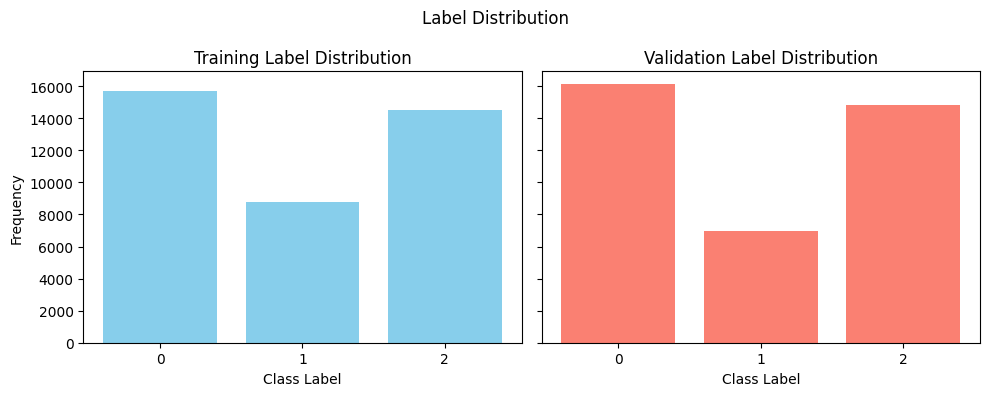

In [6]:
train_dataset, val_dataset = load_fi2010(TEST_RATIO, NORMALIZATION, stock, 
                                                       train_days, test_days, T, k, True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training Data Size : {train_dataset.__len__()}")
print(f"Validation Data Size : {val_dataset.__len__()}")

plot_label_distributions(train_dataset, val_dataset)

In [7]:
model_deepLOB = Deeplob().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deepLOB.parameters(), lr=LEARNING_RATE)

summary(model_deepLOB, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
Deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

In [8]:
### If MINI, do not save model 

if not MINI: 
    history = train_validate(model_deepLOB, train_loader, val_loader, optimizer, criterion, EPOCHS, NORMALIZATION, DATASET_TYPE, device)
else:
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model_deepLOB, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model_deepLOB, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{EPOCHS}: "
              f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

Epoch 1/3: Train Loss 1.0291 | Train Acc 0.4932 | Val Loss 1.0236 | Val Acc 0.4896
Epoch 2/3: Train Loss 0.9197 | Train Acc 0.6256 | Val Loss 1.0019 | Val Acc 0.5222
Epoch 3/3: Train Loss 0.8599 | Train Acc 0.6899 | Val Loss 1.0068 | Val Acc 0.5212


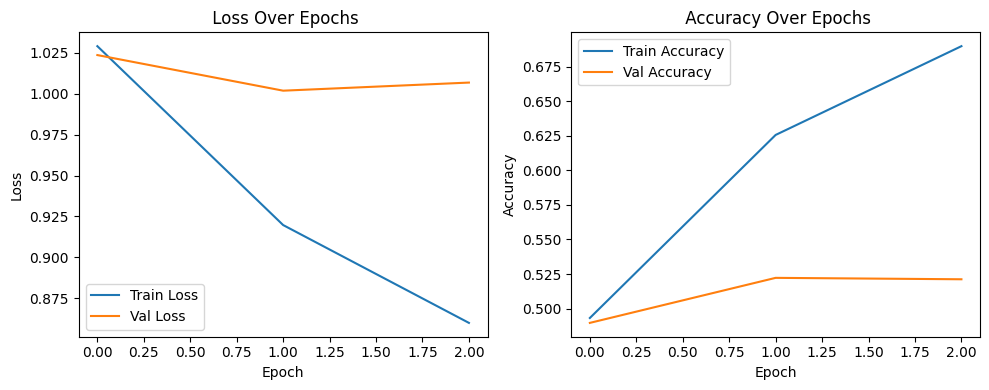

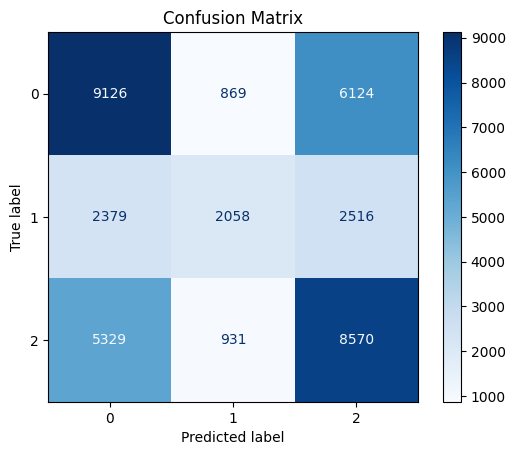

              precision    recall  f1-score   support

           0     0.5421    0.5662    0.5539     16119
           1     0.5334    0.2960    0.3807      6953
           2     0.4980    0.5779    0.5350     14830

    accuracy                         0.5212     37902
   macro avg     0.5245    0.4800    0.4899     37902
weighted avg     0.5232    0.5212    0.5147     37902

Test Accuracy: 0.5212
Test Precision (macro): 0.5245
Test Recall (macro): 0.4800
Test F1 Score (macro): 0.4899


In [9]:
plot_training_history(history)
evaluate(model_deepLOB, val_loader, device)

# TransLOB

Training Data Size : 39017
Validation Data Size : 37902


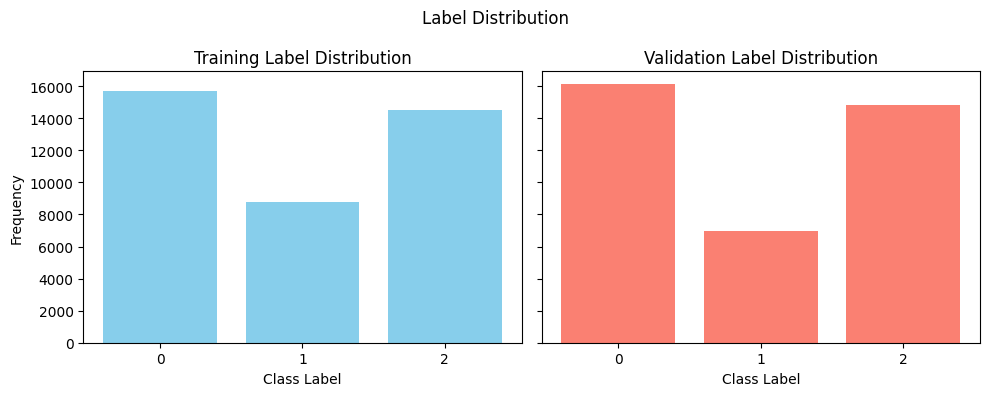

In [10]:
train_dataset, val_dataset = load_fi2010(TEST_RATIO, NORMALIZATION, stock, 
                                                       train_days, test_days, T, k, False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training Data Size : {train_dataset.__len__()}")
print(f"Validation Data Size : {val_dataset.__len__()}")

plot_label_distributions(train_dataset, val_dataset)

In [11]:
model_transLOB = TransLOB().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transLOB.parameters(), lr=LEARNING_RATE)

summary(model_transLOB, (1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
TransLOB                                 [1, 3]                    --
├─LOBFeatureExtractor: 1-1               [1, 100, 14]              --
│    └─Conv1d: 2-1                       [1, 14, 100]              1,134
│    └─Conv1d: 2-2                       [1, 14, 100]              406
│    └─Conv1d: 2-3                       [1, 14, 100]              406
│    └─Conv1d: 2-4                       [1, 14, 100]              406
│    └─Conv1d: 2-5                       [1, 14, 100]              406
├─LayerNorm: 1-2                         [1, 100, 14]              28
├─LOBPositionalEncoding: 1-3             [1, 100, 15]              --
├─LOBTransformerBlock: 1-4               [1, 100, 15]              --
│    └─MultiheadAttention: 2-6           [1, 100, 15]              960
│    └─LayerNorm: 2-7                    [1, 100, 15]              30
│    └─Sequential: 2-8                   [1, 100, 15]              --
│    │ 

Epoch 1/3: Train Loss 1.0807 | Train Acc 0.3800 | Val Loss 1.0484 | Val Acc 0.4250
Epoch 2/3: Train Loss 1.0330 | Train Acc 0.4340 | Val Loss 1.0340 | Val Acc 0.4149
Epoch 3/3: Train Loss 0.9978 | Train Acc 0.4579 | Val Loss 1.0358 | Val Acc 0.4103


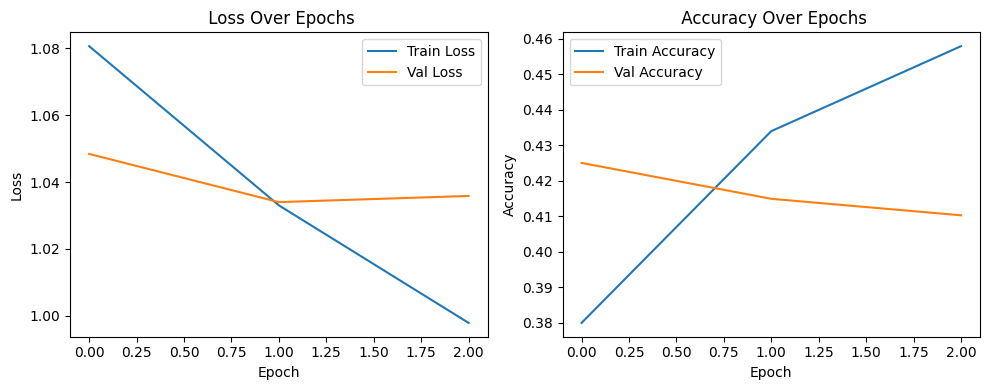

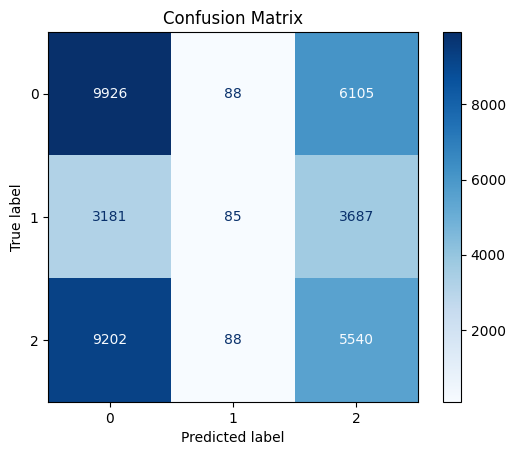

              precision    recall  f1-score   support

           0     0.4449    0.6158    0.5166     16119
           1     0.3257    0.0122    0.0236      6953
           2     0.3613    0.3736    0.3673     14830

    accuracy                         0.4103     37902
   macro avg     0.3773    0.3339    0.3025     37902
weighted avg     0.3903    0.4103    0.3678     37902

Test Accuracy: 0.4103
Test Precision (macro): 0.3773
Test Recall (macro): 0.3339
Test F1 Score (macro): 0.3025


In [12]:
### If MINI, do not save model 

if not MINI: 
    history = train_validate(model_transLOB, train_loader, val_loader, optimizer, criterion, EPOCHS, NORMALIZATION, DATASET_TYPE, device)
else:
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model_transLOB, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model_transLOB, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{EPOCHS}: "
              f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

plot_training_history(history)
evaluate(model_transLOB, val_loader, device)

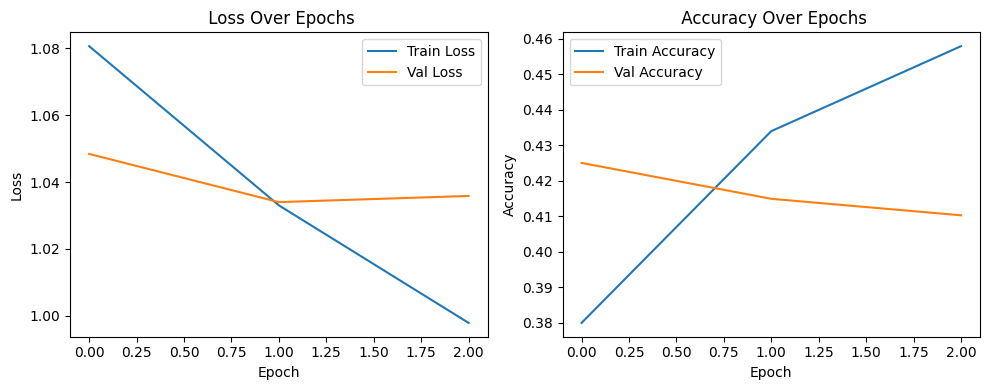

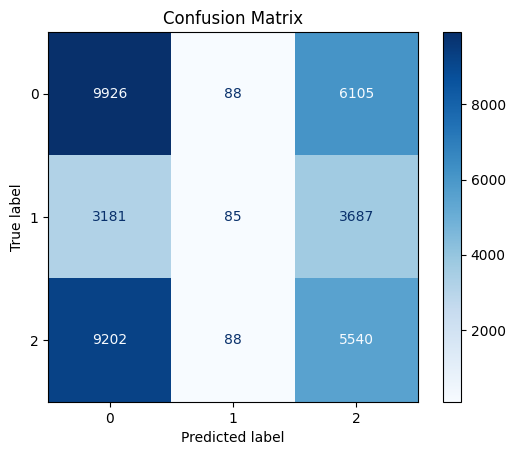

              precision    recall  f1-score   support

           0     0.4449    0.6158    0.5166     16119
           1     0.3257    0.0122    0.0236      6953
           2     0.3613    0.3736    0.3673     14830

    accuracy                         0.4103     37902
   macro avg     0.3773    0.3339    0.3025     37902
weighted avg     0.3903    0.4103    0.3678     37902

Test Accuracy: 0.4103
Test Precision (macro): 0.3773
Test Recall (macro): 0.3339
Test F1 Score (macro): 0.3025


In [13]:
plot_training_history(history)
evaluate(model_transLOB, val_loader, device)

# DeepTransLOB

Training Data Size : 254255
Validation Data Size : 138102


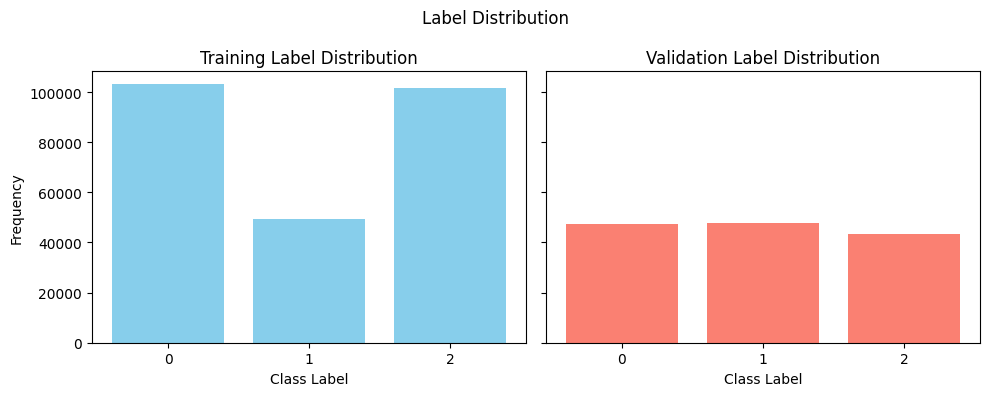

In [36]:
train_dataset, val_dataset = load_fi2010(TEST_RATIO, NORMALIZATION, stock, 
                                                       train_days, test_days, T, k, False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training Data Size : {train_dataset.__len__()}")
print(f"Validation Data Size : {val_dataset.__len__()}")

plot_label_distributions(train_dataset, val_dataset)

In [37]:
model_deepTransLOB = DeepTransLOB().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deepTransLOB.parameters(), lr=LEARNING_RATE)

summary(model_deepTransLOB, (1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
DeepTransLOB                             [1, 3]                    --
├─LOBFeatureExtractor2D: 1-1             [1, 100, 64]              --
│    └─Sequential: 2-1                   [1, 64, 100, 20]          --
│    │    └─CausalConv2d: 3-1            [1, 64, 100, 20]          192
│    │    └─LeakyReLU: 3-2               [1, 64, 100, 20]          --
│    │    └─BatchNorm2d: 3-3             [1, 64, 100, 20]          128
│    │    └─CausalConv2d: 3-4            [1, 64, 100, 20]          12,352
│    │    └─LeakyReLU: 3-5               [1, 64, 100, 20]          --
│    │    └─BatchNorm2d: 3-6             [1, 64, 100, 20]          128
│    │    └─CausalConv2d: 3-7            [1, 64, 100, 20]          12,352
│    │    └─LeakyReLU: 3-8               [1, 64, 100, 20]          --
│    │    └─BatchNorm2d: 3-9             [1, 64, 100, 20]          128
│    └─Sequential: 2-2                   [1, 64, 100, 10]          --
│  

In [ ]:
### If MINI, do not save model 

if not MINI: 
    history = train_validate(model_deepTransLOB, train_loader, val_loader, optimizer, criterion, EPOCHS, NORMALIZATION, DATASET_TYPE, device)
else:
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model_deepTransLOB, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model_deepTransLOB, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{EPOCHS}: "
              f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

Epoch 1/50, Train Loss: 0.8355, Train Acc: 0.6017, Validation Loss: 0.7558, Validation Acc: 0.6671
Epoch 2/50, Train Loss: 0.6651, Train Acc: 0.7171, Validation Loss: 0.6994, Validation Acc: 0.7149
Epoch 3/50, Train Loss: 0.5824, Train Acc: 0.7646, Validation Loss: 0.6984, Validation Acc: 0.7242
Epoch 4/50, Train Loss: 0.5331, Train Acc: 0.7891, Validation Loss: 0.6579, Validation Acc: 0.7354
Epoch 5/50, Train Loss: 0.4963, Train Acc: 0.8072, Validation Loss: 0.6717, Validation Acc: 0.7334
Epoch 6/50, Train Loss: 0.4651, Train Acc: 0.8210, Validation Loss: 0.6826, Validation Acc: 0.7300
Epoch 7/50, Train Loss: 0.4388, Train Acc: 0.8327, Validation Loss: 0.6989, Validation Acc: 0.7268
Epoch 8/50, Train Loss: 0.4159, Train Acc: 0.8431, Validation Loss: 0.7326, Validation Acc: 0.7272
Epoch 9/50, Train Loss: 0.3937, Train Acc: 0.8526, Validation Loss: 0.7466, Validation Acc: 0.7288
Epoch 10/50, Train Loss: 0.3754, Train Acc: 0.8609, Validation Loss: 0.7580, Validation Acc: 0.7245
Epoch 11/

In [ ]:
plot_training_history(history)
evaluate(model_deepTransLOB, val_loader, device)